In [1]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Common_Functions as cf 
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras import models 
import os
from keras.regularizers import l2
plt.rc('font', family='serif')
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
os.environ['CUDA_VISIBLE_DEVICES'] = '0'


In [2]:
# First data set is control
# Load Djuna Pion Data
df_pions = np.array(pd.read_csv('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/testing_data.csv',header = None))
df_pions[:,-1] = -df_pions[:,-1]
#Holdout validation splitting 
train_x, train_y = df_pions[:-10000,:-1], (df_pions[:-10000,-1])
val_x, val_y = df_pions[-10000:,:-1], (df_pions[-10000:,-1])

#Second Data Set
#Netowork Trained on Pion Values Plus Potential(Train/Val Y) 
train_x_inc_y, train_y = df_pions[:-10000,], (df_pions[:-10000,-1])
val_x_inc_y, val_y = df_pions[-10000:], (df_pions[-10000:,-1])


#Third Data Set
#Network trained on random numbers Plus Potential
random_array = np.random.rand(df_pions.shape[0],16)
random_array_inc_y = np.hstack((random_array,np.expand_dims(df_pions[:,-1],axis= 1)))
#Holdout Valiation Splitting
rand_train_x_inc_y, rand_train_y = random_array_inc_y[:-10000,], (random_array_inc_y[:-10000,-1])
rand_val_x_inc_y, rand_val_y = random_array_inc_y[-10000:], (random_array_inc_y[-10000:,-1])


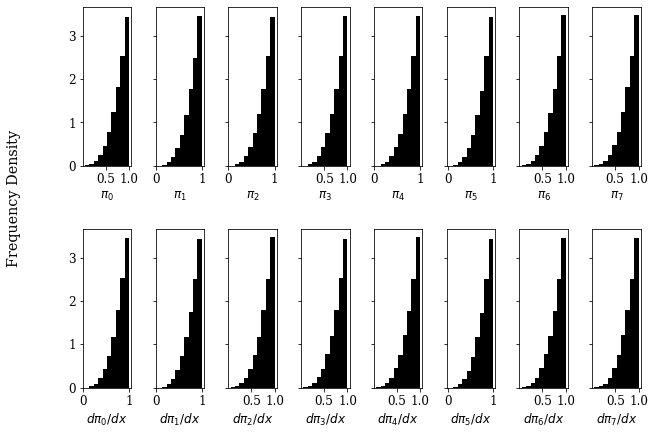

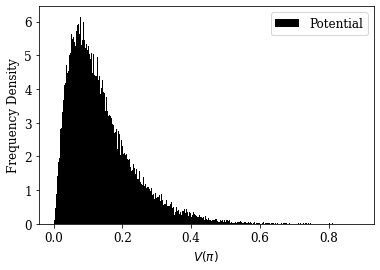

In [3]:
# Plotting Distribution of the input vector for the control case
fig , ax = plt.subplots(2,8,sharey= True, figsize = (10,7))
plt.subplots_adjust(hspace= 0.4,wspace= 0.5)
for i in range(8):
    ax[0,i].hist(df_pions[:,i], density = True, color = 'black', ) 
    ax[1,i].hist(df_pions[:,8+i],density = True, color = 'black')
    ax[0,i].set_xlabel('$\pi_{{{}}}$'.format(i))
    ax[1,i].set_xlabel('$ d\pi_{{{}}}/dx$'.format(i))
    #ax[2,i].hist(df_pions[:,i],density = True,color = 'black')
fig.supylabel('Frequency Density')

#Plotting Potential Y values
fig_2 = plt.figure()
plt.hist(train_y,density= True, bins = 1000, color = 'black',label=  'Potential')
plt.xlabel('$V(\pi)$')
plt.ylabel('Frequency Density')
plt.legend()

In [4]:
##Optimiser for Network
opt = keras.optimizers.Adam(learning_rate= 0.001,amsgrad= True)
num_epoch = 100

In [5]:
#Build Network
#Control
model1 = cf.trained_network(train_x,train_y,val_x,val_y, [512,512,512],optimizer=opt,epochs= num_epoch, model_summary= True).history
cf.reset()
# Including Y
model2 = cf.trained_network(train_x_inc_y,train_y,val_x_inc_y,val_y,[512,512,512],optimizer=opt,epochs= num_epoch, model_summary= True).history
cf.reset()
# Random
model3 = cf.trained_network(rand_train_x_inc_y,train_y,rand_val_x_inc_y,val_y,[512,512,512],optimizer=opt,epochs= num_epoch, model_summary= True).history

2021-11-30 13:24:28.836959: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2021-11-30 13:24:28.837000: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: Sean-PC
2021-11-30 13:24:28.837009: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: Sean-PC
2021-11-30 13:24:28.837110: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.86.0
2021-11-30 13:24:28.837136: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.82.0
2021-11-30 13:24:28.837143: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.82.0 does not match DSO version 470.86.0 -- cannot find working devices in this configuration
2021-11-30 13:24:28.837767: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow b

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               8704      
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 534,529
Trainable params: 534,529
Non-trainable params: 0
_________________________________________________________________
Memory Reset
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               9216      
_____________

In [6]:
model_dicts = [model1,model2,model3]

In [20]:
#smoothing the histories
val_mape_smooth =[]
loss_smooth = []
for i in range(3): 
    val_mape = np.array(model_dicts[i]['val_mean_absolute_percentage_error'])
    loss = np.array(model_dicts[i]['loss'])
    loss_smooth.append(cf.exponetial_smoothing(loss,0.5))
    val_mape_smooth.append(cf.exponetial_smoothing(val_mape,0.3))
    
epochs = np.arange(1,num_epoch+1)

Train X Input Vector Minimum Val MAPE =  2.7 Minimum Loss Mape =  2.6
Train X $ \oplus$ Train Y Input Vector Minimum Val MAPE =  0.4 Minimum Loss Mape =  0.7
Radom X $ \oplus$ Train Y Input Vector Minimum Val MAPE =  0.4 Minimum Loss Mape =  0.5


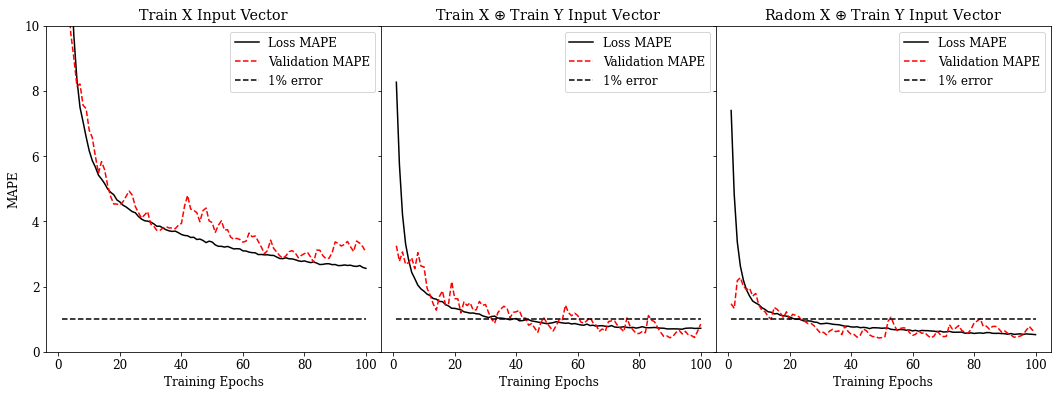

In [40]:
#Plotting results
titles = ['Train X Input Vector',r'Train X $ \oplus$ Train Y Input Vector', r'Radom X $ \oplus$ Train Y Input Vector']
matplotlib.rcParams.update({'legend.fontsize': 12})
fig_3, axs  = plt.subplots(1,3, figsize= (18,6), sharey = True)
fig_3.subplots_adjust(wspace= 0)
for i in range(3):
    print(titles[i],'Minimum Val MAPE = ',round(np.min(val_mape_smooth[i]),1), 'Minimum Loss Mape = ',round(np.min(loss_smooth[i]),1))
    axs[i].plot(epochs,loss_smooth[i], label = 'Loss MAPE', c = 'black')
    axs[i].plot(epochs,val_mape_smooth[i],label = 'Validation MAPE', c = 'red',linestyle = '--')
    axs[i].plot(epochs, np.ones_like(epochs), linestyle = '--',c = 'black', label = '1% error')
    axs[i].set_ylim(0,10)
    axs[i].legend()
    axs[i].set_xlabel('Training Epochs')
    axs[i].set_title(titles[i])
axs[0].set_ylabel('MAPE')
fig_3.savefig('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Figures/netowork_convergance_on_random_input_plus_output.png',dpi = 300)